# i4talent assessment opdracht
i4talent begon ooit als detacheerder van finance professionals en later ook van data analisten.

Nu we een data science consultancy unit hebben, heeft de detachering unit ons gevraagd of wij ze kunnen helpen met een volgende probleem: de (te hoge) uitstroom van professionals. Dit zijn
professionals die zelf weggaan, ontslagen worden of met pensioen gaan. i4talent wil graag de uitstroom minimaliseren.

In deze opdracht kijken we of de de data van i4talent kunnen gebruiken om de uitstroom te voorspellen en mogelijk te minimaliseren.


### Import libraries
We starten met het importeren van een aantal libraries die we nodig zullen hebben voor deze opdracht.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import joblib

### Data laden


In [2]:
# Defining data for the dataframe
data = pd.read_csv('i4talent.csv')
data.columns = map(str.lower, data.columns)

## Data opschonen
Laten we eerst kijken naar ontbrekende data en een nieuwe binaire kolom toe te voegen voor werkstatus

In [3]:
data["gestopt"] = data["status"].apply(lambda x : 1 if x=="Beëindigd" else 0)
# Sort the DataFrame by 'werknemerid' and 'status_jaar' in descending order
data_sorted = data.sort_values(by=['werknemerid', 'status_jaar'], ascending=[True, False])

# Drop duplicates, keeping only the first (most recent) occurrence of each 'werknemerid'
data_unique = data_sorted.drop_duplicates(subset='werknemerid', keep='first')
data_unique = data_unique.reset_index(drop=True)

data_unique["datum"] = pd.to_datetime(data_unique["datum"])
data_unique["geboortedatum"] = pd.to_datetime(data_unique["geboortedatum"])
data_unique["indiensttreding_datum"] = pd.to_datetime(data_unique["indiensttreding_datum"])
data_unique['uitdiensttreding_datum'] = pd.to_datetime(data_unique['uitdiensttreding_datum'])

print(data_unique.columns[data_unique.isna().any()].tolist())

['leeftijd', 'lengte_dienst', 'stad', 'afdeling']


De volgende kolommen missen data: Leeftijd, lengte_dienst, stad, afdeling. Hiervoor nemen we de volgende stappen:

- Leeftijd: Als we een leeftijd missen, maar wel een geboortedatum hebben, kunnen we deze herleiden met de geboortedatum en statusjaar. De geboortedatum ronden we af op het jaar.

- Lengte_dienst: De dienstlengte kunnen we herleiden vanuit de indiensttreding datum en statusjaar op eenzelfde wijze.

- Voor de stad en afdeling vullen we 'onbekend' in. Alternatieve keuze is om de modus van deze gegevens in te vullen. Op dit moment heb ik nog geen sterk vermoeden om te denken dat dit veel effect zal hebben.

In [4]:
missende_leeftijden = np.where(data_unique["leeftijd"].isna())[0]
geboortedatum = data_unique["geboortedatum"]
geboortejaar = np.where(
    (geboortedatum.dt.month < 7), geboortedatum.dt.year,geboortedatum.dt.year + 1)
leeftijd = data_unique["status_jaar"] - geboortejaar
data_unique.loc[missende_leeftijden, 'leeftijd'] = leeftijd

missende_dienstjaar = np.where(data_unique["lengte_dienst"].isna())[0]
indiensttreding_datum = data_unique["indiensttreding_datum"]
indiensttrading_jaar = np.where(
    (indiensttreding_datum.dt.month < 7), indiensttreding_datum.dt.year,indiensttreding_datum.dt.year + 1)
lengte_dienst = data_unique["status_jaar"] - indiensttrading_jaar
data_unique.loc[missende_dienstjaar, 'lengte_dienst'] = lengte_dienst

missende_stad = np.where(data_unique["stad"].isna())[0]
data_unique.loc[missende_stad, 'stad'] = 'Onbekend'

missende_afdeling = np.where(data_unique["afdeling"].isna())[0]
data_unique.loc[missende_afdeling, 'afdeling'] = 'Onbekend'

Nu de data geen missende gegevens heeft, ben ik benieuwd hoe de data eruit ziet. Zijn er globale trends aanwezig? Is er op oog omslag verschillen aanwezig bij de groep die gestopt is vs de groep die werkzaam is?

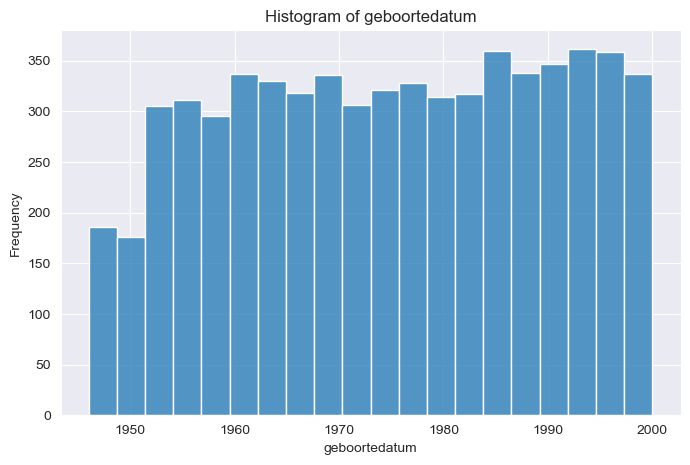

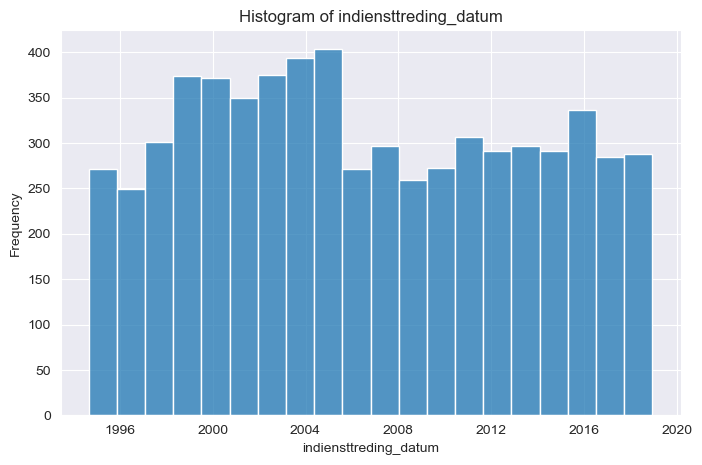

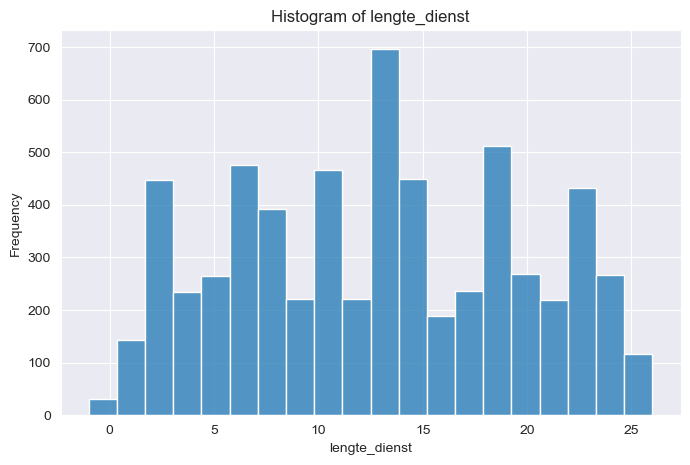

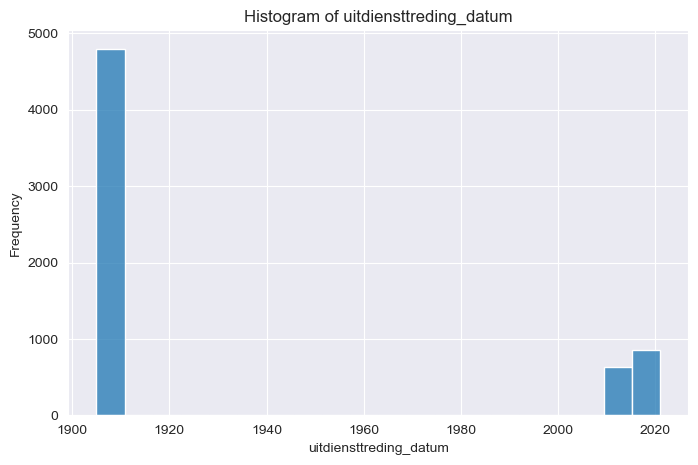

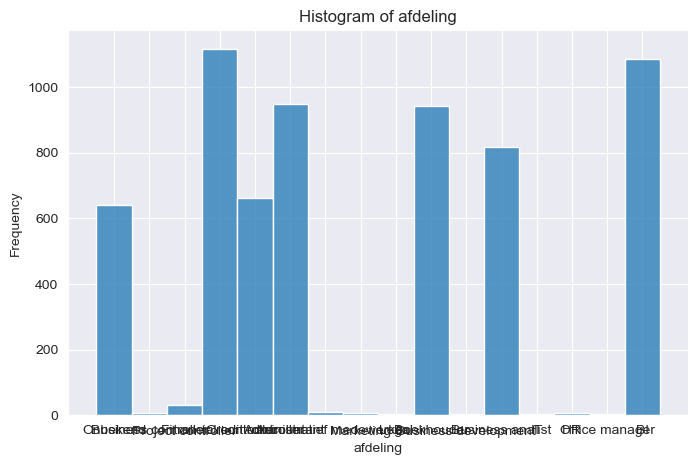

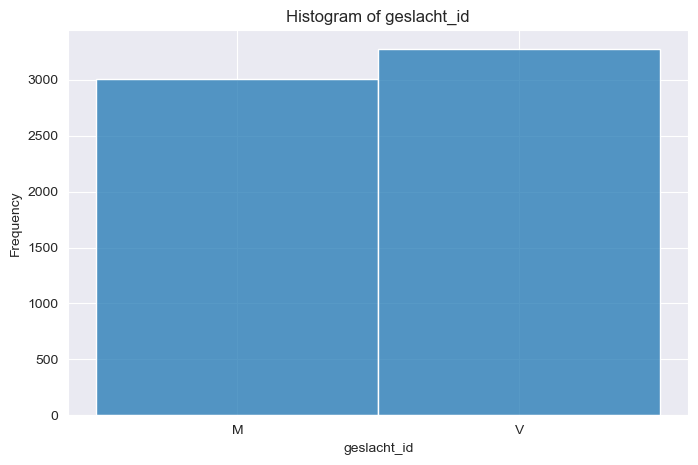

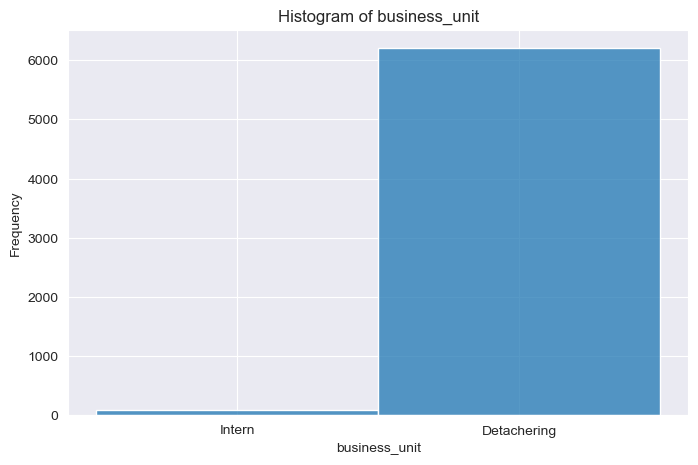

In [5]:
bin_size = 20

columns = ["geboortedatum", "indiensttreding_datum", "lengte_dienst", "uitdiensttreding_datum", "afdeling", "geslacht_id", "business_unit"]
data_selected = data_unique[columns]
for column in data_selected.columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(data_selected[column], bins = bin_size)  # kde=True adds a Kernel Density Estimate curve
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

We zien op dit moment een aantal dingen in de globale populatie: De geboortedatum lijkt normaal verdeeld, eveneens de indiensttreding. Er zijn een aantal pieken in dienstjaren, wat mogelijk suggereert dat mensen globaal een x aantal jaren blijft.
Een aantal afdeling representeren de grootste deel van de populatie. Man en vrouw zijn redelijk goed verdeeld, en tot slot, de meeste mensen werken in detachering. Ik wil nu kijken hoe dit is gesplitst is tussen gestopte en werkzame medewerkers.

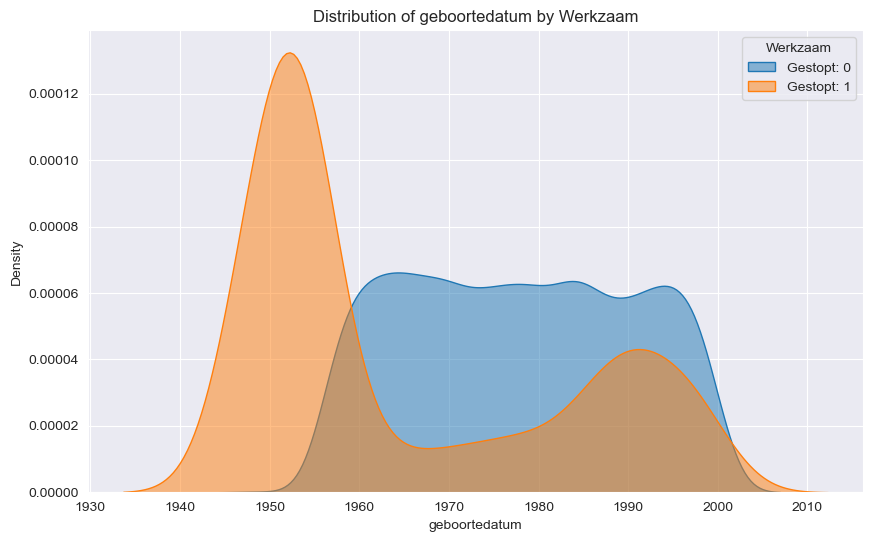

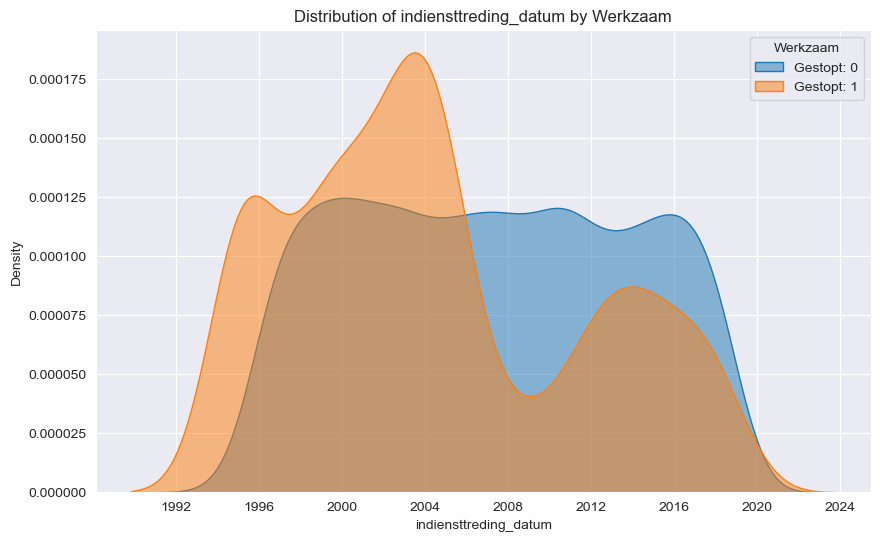

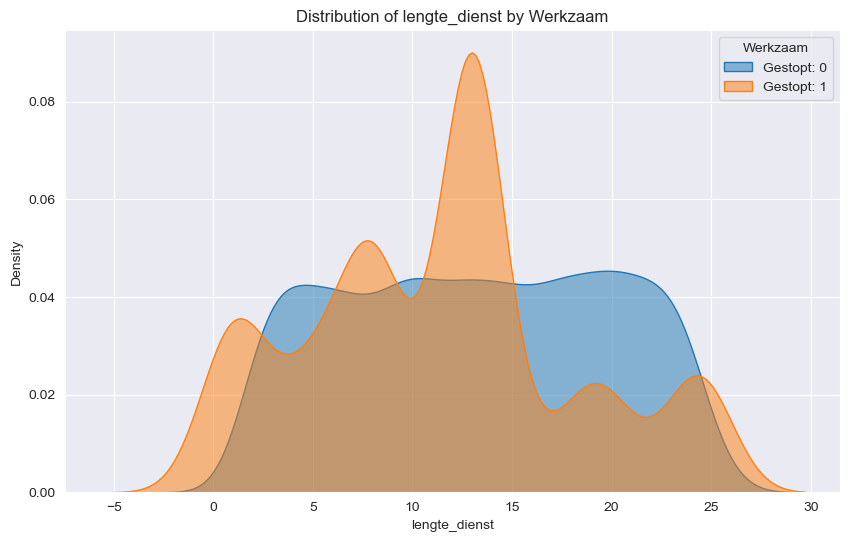

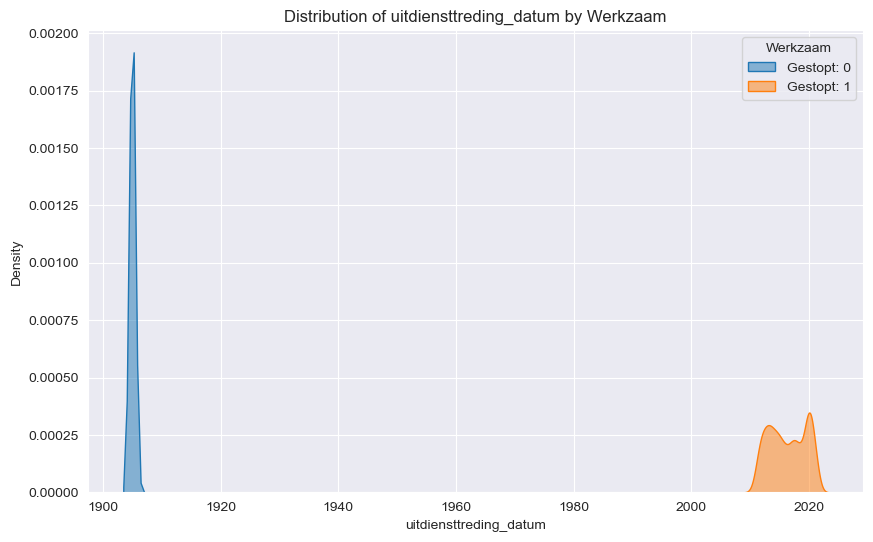

In [6]:
columns = ["geboortedatum", "indiensttreding_datum", "lengte_dienst", "uitdiensttreding_datum"]
data_selected = data_unique[columns + ["gestopt"]]  # Ensure 'werkzaam' is included

# Iterate over selected columns, excluding 'werkzaam'
for column in columns:
    plt.figure(figsize=(10, 6))

    # Plot KDE for each category in 'werkzaam'
    for werkzaam_category in data_selected['gestopt'].unique():
        sns.kdeplot(
            data=data_selected[data_selected['gestopt'] == werkzaam_category],
            x=column,
            label=f"Gestopt: {werkzaam_category}",
            fill=True,  # Optional: fills the area under the curve
            alpha=0.5  # Adjust transparency        
        )
        plt.title(f'Distribution of {column} by Werkzaam')
    plt.xlabel(column)
    plt.ylabel('Density')

    # Explicitly display the legend
    plt.legend(title='Werkzaam')
    plt.show()

In [7]:
outflow_rate = data_unique['gestopt'].mean()
print(f"Overall Outflow Rate: {outflow_rate:.2%}")

Overall Outflow Rate: 23.58%


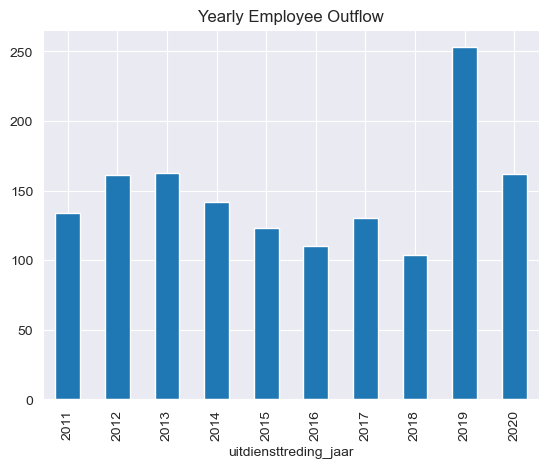

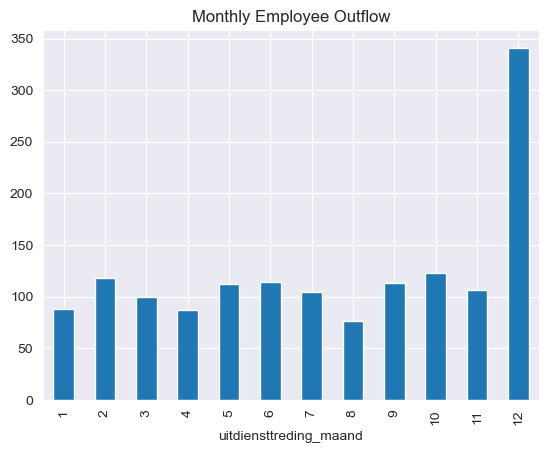

In [219]:
data_unique['uitdiensttreding_jaar'] = data_unique['uitdiensttreding_datum'].dt.year
data_unique['uitdiensttreding_maand'] = data_unique['uitdiensttreding_datum'].dt.month

yearly_outflow = data_unique[data_unique['uitdiensttreding_jaar'] > 1905].groupby('uitdiensttreding_jaar')['gestopt'].sum()
monthly_outflow = data_unique.groupby('uitdiensttreding_maand')['gestopt'].sum()

yearly_outflow.plot(kind='bar', title='Yearly Employee Outflow')
plt.show()

monthly_outflow.plot(kind='bar', title='Monthly Employee Outflow')
plt.show()

In [275]:
data_unique['uitdiensttreding_datum'] = pd.to_datetime(data_unique['uitdiensttreding_datum'])
december_2019_data = data_unique[
    data_unique['uitdiensttreding_datum'].dt.year == 2018
    ]

# Count occurrences of each reason in December 2019
december_2019_reasons = december_2019_data['uitdiensttreding_reden'].value_counts()
total_december_2019 = len(december_2019_data)


# Output the results
print(f"Total people who left in December 2019: {total_december_2019}")
print("\nBreakdown of reasons for leaving in December 2019:")
print(december_2019_reasons)

Total people who left in December 2019: 105

Breakdown of reasons for leaving in December 2019:
uitdiensttreding_reden
Pensioen               56
Vertrek                48
Niet van toepassing     1
Name: count, dtype: int64


In [221]:
# Count occurrences of each reason in the entire dataset
data_filtered = data_unique[data_unique['uitdiensttreding_jaar'] > 1905]
reason_counts = data_filtered['uitdiensttreding_reden'].value_counts()

# Get the count of fired people
fired_count = reason_counts.get('Ontslag', 0)  # Replace 'Fired' with the exact label in your dataset

# Calculate the proportion of fired people
total_leavers = len(data_filtered)
fired_proportion = fired_count / total_leavers if total_leavers > 0 else 0

# Output the results
print(f"Total people who left: {total_leavers}")
print(f"Number of fired people: {fired_count}")
print(f"Proportion of fired people: {fired_proportion:.2%}")
print("\nBreakdown of reasons for leaving:")
print(reason_counts)

Total people who left: 1485
Number of fired people: 215
Proportion of fired people: 14.48%

Breakdown of reasons for leaving:
uitdiensttreding_reden
Pensioen               883
Vertrek                384
Ontslag                215
Niet van toepassing      3
Name: count, dtype: int64


Conclusies so far:
- Meeste mensen die gestopt zijn, zijn gestopt wegens pensioen. Dat verklaart ook de verdeling van geboortedatum.
- In december gaan de meeste mensen gemiddeld weg, maar dit is vooral door ontslag.
- Pensioen kunnen we waarschijnlijk voorspellen door te kijken wat de gemiddelde leeftijd is van de mensen die met pensioen gaan (en evt huidige pensioenleeftijd)
- De vertrekkers zijn voor het bedrijf de minst voorspelbare en juist over die populatie willen we wat zeggen.

Gemiddelde leeftijd op uitdiensttreding pensioen:

In [8]:
data_unique_pensioen = data_unique[data_unique['uitdiensttreding_reden'] == 'Pensioen']
gem_leeftijd_pensioen = data_unique_pensioen["leeftijd"].mean()
print(f"Gemiddelde leeftijd uitdiensttreding pensioen: {gem_leeftijd_pensioen:.3}")


Gemiddelde leeftijd uitdiensttreding pensioen: 63.3


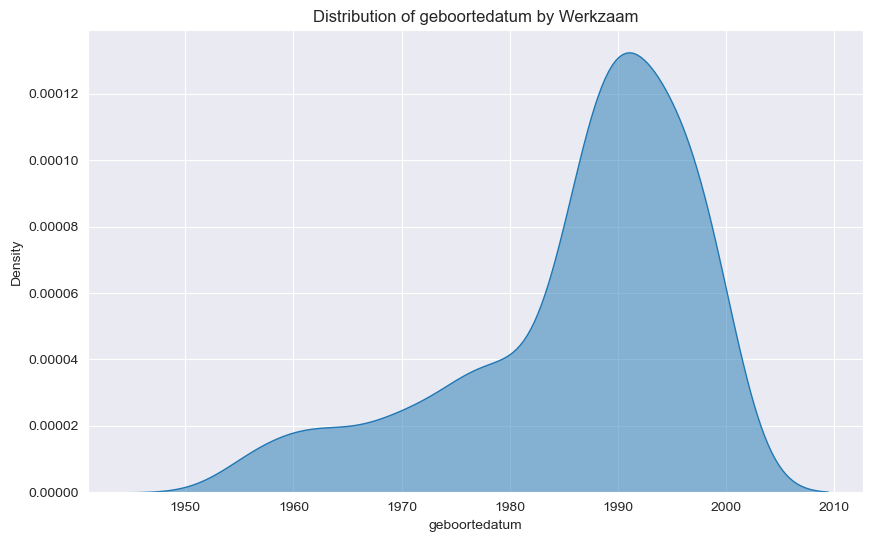

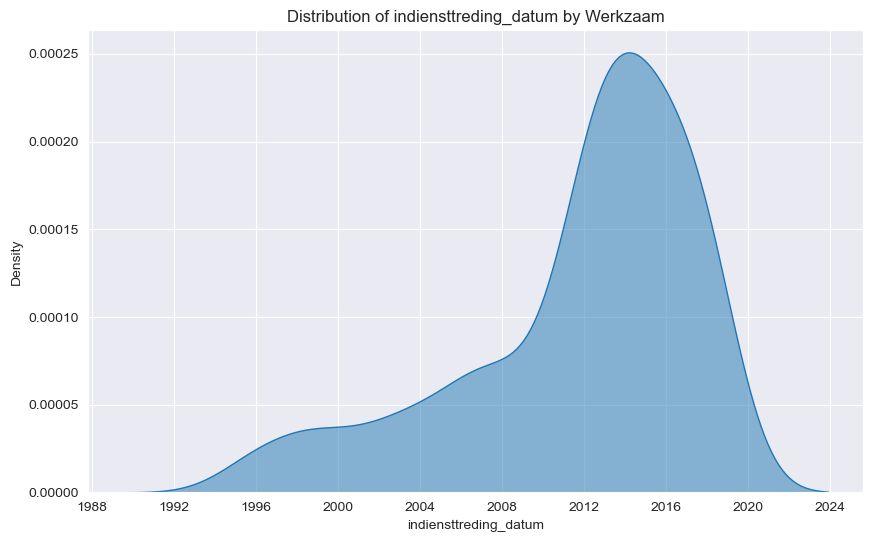

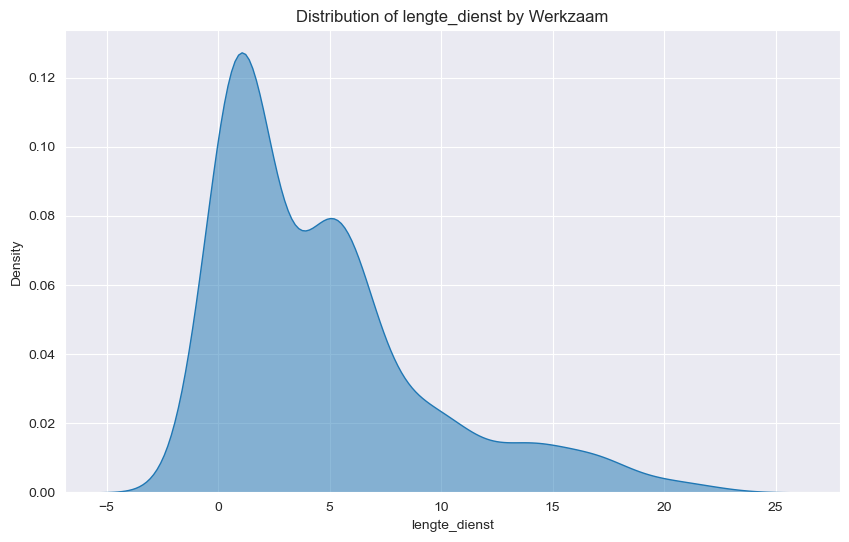

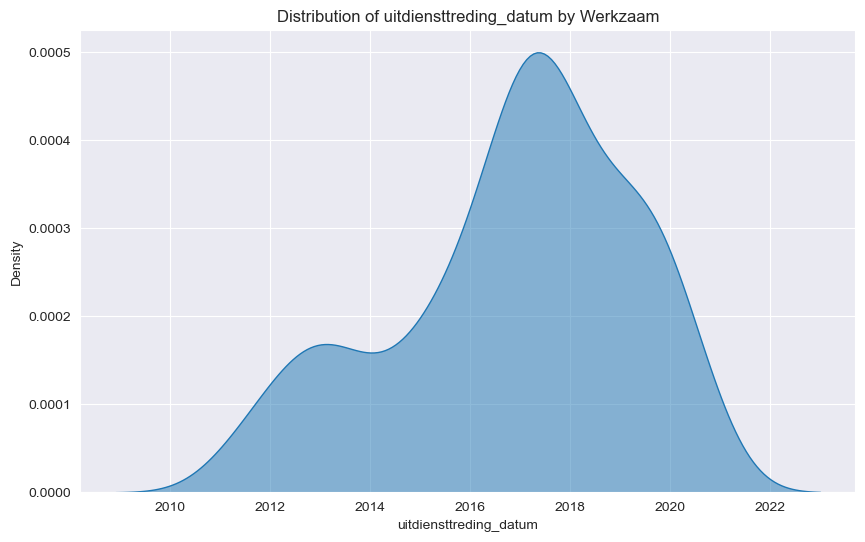

In [10]:
data_vertrek = data_unique[data_unique['uitdiensttreding_reden'] == 'Vertrek']
columns = ["geboortedatum", "indiensttreding_datum", "lengte_dienst", "uitdiensttreding_datum"]

# Iterate over selected columns, excluding 'werkzaam'
for column in columns:
    plt.figure(figsize=(10, 6))

    # Plot KDE for each category in 'werkzaam'

    sns.kdeplot(
        data=data_vertrek,
        x=column,
        fill=True,  # Optional: fills the area under the curve
        alpha=0.5  # Adjust transparency        
    )
    plt.title(f'Distribution of {column} by Werkzaam')
    plt.xlabel(column)
    plt.ylabel('Density')

    # Explicitly display the legend
    plt.show()

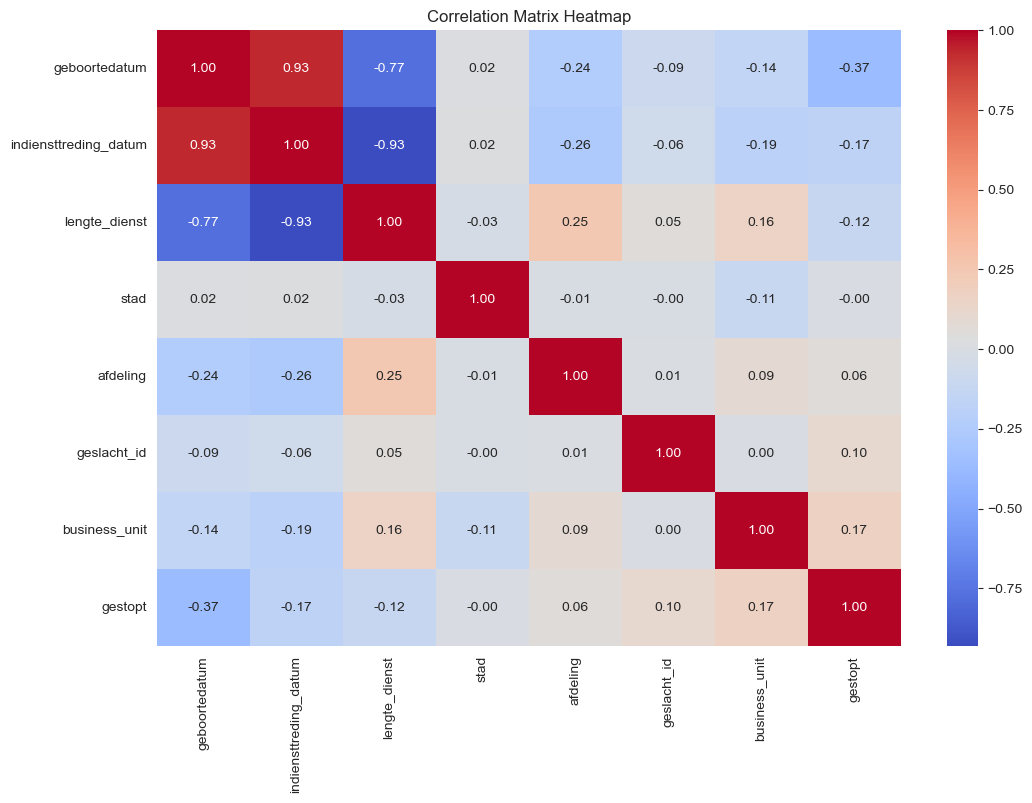

In [224]:
# List of categorical columns to encode
categorical_columns = [
    "stad", "afdeling", "geslacht_id", "business_unit", "gestopt"
]

columns = ["geboortedatum", "indiensttreding_datum", "lengte_dienst", "stad", "afdeling", "geslacht_id", "business_unit", "gestopt"]
data_filtered = data_unique[columns]
# Create a copy of the data to avoid modifying the original
data_encoded = data_filtered.copy()

# Initialize the label encoder
label_encoder = LabelEncoder()

# Encode each categorical column
for column in categorical_columns:
    data_encoded[column] = label_encoder.fit_transform(data_encoded[column].astype(str))

# Compute correlations
correlation_matrix = data_encoded.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Matrix Heatmap")
plt.show()

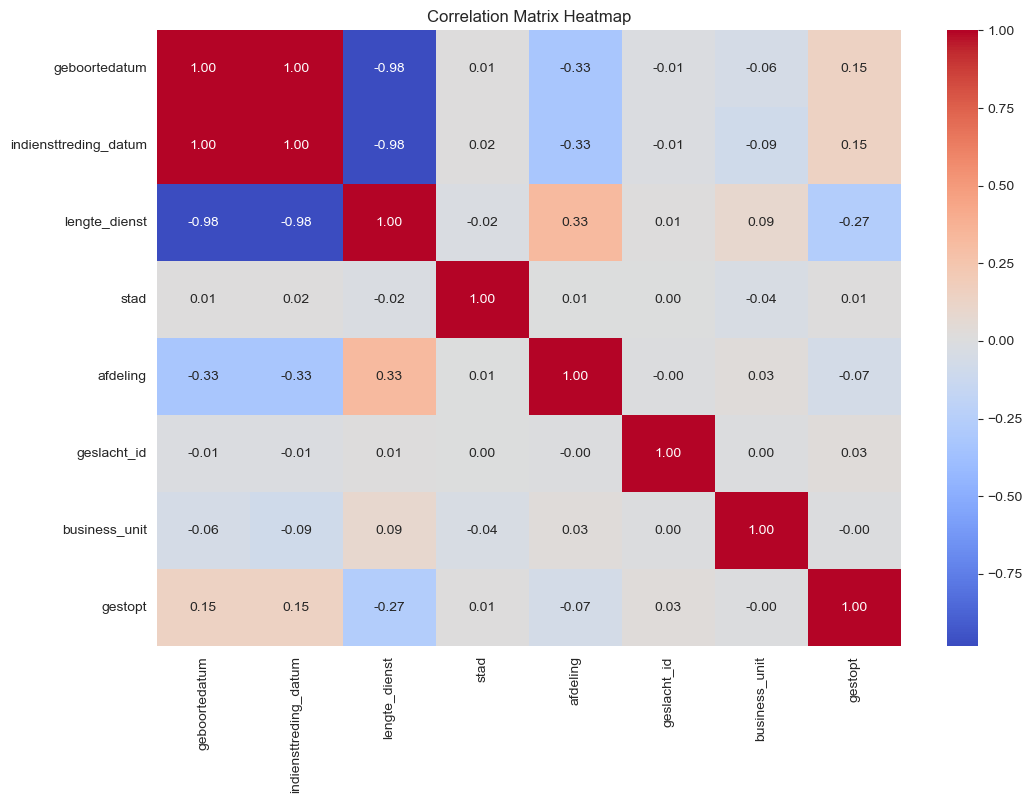

In [225]:
# List of categorical columns to encode
categorical_columns = [
    "stad", "afdeling", "geslacht_id", "business_unit", "gestopt"
]

columns = ["geboortedatum", "indiensttreding_datum", "lengte_dienst", "stad", "afdeling", "geslacht_id", "business_unit", "gestopt"]
data_filtered = data_unique[data_unique["uitdiensttreding_reden"] != 'Pensioen']
data_filtered = data_filtered[columns]

# Create a copy of the data to avoid modifying the original
data_encoded = data_filtered.copy()

# Initialize the label encoder
label_encoder = LabelEncoder()

# Encode each categorical column
for column in categorical_columns:
    data_encoded[column] = label_encoder.fit_transform(data_encoded[column].astype(str))

# Compute correlations
correlation_matrix = data_encoded.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [12]:
# Create a copy of the data to avoid modifying the original
columns = ["geboortedatum", "indiensttreding_datum", "lengte_dienst", "stad", "afdeling", "geslacht_id", "business_unit", "gestopt"]
data_filtered = data_unique[columns]
data_processed = data_filtered.copy()

# Convert date columns to Unix timestamps
data_processed['geboortedatum_unix'] = pd.to_datetime(data_processed['geboortedatum']).astype('int64') / 10**9
data_processed['indiensttreding_unix'] = pd.to_datetime(data_processed['indiensttreding_datum']).astype('int64') / 10**9

# Encode categorical columns
categorical_columns = ['afdeling', 'business_unit']  # Add more categorical columns if needed
label_encoder = LabelEncoder()
for column in categorical_columns:
    data_processed[column] = label_encoder.fit_transform(data_processed[column].astype(str))

# Select features and target
X_all = data_processed[['geboortedatum_unix', 'lengte_dienst', 'afdeling', 'business_unit']]  # Add relevant features
y_all = data_processed['gestopt']

# Fit the Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_all, y_all)

# Get feature importances
feature_importances = model.feature_importances_

# Display feature importances
for feature, importance in zip(X_all.columns, feature_importances):
    print(f"Feature: {feature}, Importance: {importance:.4f}")

Feature: geboortedatum_unix, Importance: 0.7597
Feature: lengte_dienst, Importance: 0.2110
Feature: afdeling, Importance: 0.0215
Feature: business_unit, Importance: 0.0079


In [13]:
columns = ["geboortedatum", "indiensttreding_datum", "lengte_dienst", "stad", "afdeling", "geslacht_id", "business_unit", "gestopt"]
data_filtered = data_unique[data_unique["uitdiensttreding_reden"] != 'Pensioen']
data_filtered = data_filtered[columns]

data_processed = data_filtered.copy()

# Convert date columns to Unix timestamps
data_processed['geboortedatum_unix'] = pd.to_datetime(data_processed['geboortedatum']).astype('int64') / 10**9
data_processed['indiensttreding_unix'] = pd.to_datetime(data_processed['indiensttreding_datum']).astype('int64') / 10**9

# Encode categorical columns
categorical_columns = ['afdeling', 'business_unit']  # Add more categorical columns if needed
label_encoder = LabelEncoder()
for column in categorical_columns:
    data_processed[column] = label_encoder.fit_transform(data_processed[column].astype(str))

# Select features and target
X_geen_pensioen = data_processed[['geboortedatum_unix', 'lengte_dienst', 'afdeling', 'business_unit']]  # Add relevant features
y_geen_pensioen = data_processed['gestopt']

# Fit the Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_geen_pensioen, y_geen_pensioen)

# Get feature importances
feature_importances = model.feature_importances_

# Display feature importances
for feature, importance in zip(X_geen_pensioen.columns, feature_importances):
    print(f"Feature: {feature}, Importance: {importance:.4f}")

Feature: geboortedatum_unix, Importance: 0.5087
Feature: lengte_dienst, Importance: 0.4489
Feature: afdeling, Importance: 0.0420
Feature: business_unit, Importance: 0.0004


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.3, random_state=42)
# Initialize models
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')  # Suppress warnings

# Train Random Forest
rf_model.fit(X_train, y_train)

# Train XGBoost
xgb_model.fit(X_train, y_train)

# Evaluate Random Forest
rf_preds = rf_model.predict(X_test)
rf_proba = rf_model.predict_proba(X_test)[:, 1]  # For ROC-AUC
print("Random Forest Results:")
print(classification_report(y_test, rf_preds))
print("Random Forest ROC-AUC:", roc_auc_score(y_test, rf_proba))

# Evaluate XGBoost
xgb_preds = xgb_model.predict(X_test)
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]  # For ROC-AUC
print("\nXGBoost Results:")
print(classification_report(y_test, xgb_preds))
print("XGBoost ROC-AUC:", roc_auc_score(y_test, xgb_proba))

# Optional: Confusion matrices
print("\nConfusion Matrix - Random Forest")
print(confusion_matrix(y_test, rf_preds))
print("\nConfusion Matrix - XGBoost")
print(confusion_matrix(y_test, xgb_preds))

Random Forest Results:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1435
           1       0.95      0.88      0.92       451

    accuracy                           0.96      1886
   macro avg       0.96      0.93      0.95      1886
weighted avg       0.96      0.96      0.96      1886

Random Forest ROC-AUC: 0.9788298554509144

XGBoost Results:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1435
           1       0.97      0.88      0.92       451

    accuracy                           0.96      1886
   macro avg       0.97      0.94      0.95      1886
weighted avg       0.96      0.96      0.96      1886

XGBoost ROC-AUC: 0.9776617196010413

Confusion Matrix - Random Forest
[[1416   19]
 [  54  397]]

Confusion Matrix - XGBoost
[[1422   13]
 [  54  397]]


In [16]:
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required at a leaf node
    'bootstrap': [True, False]  # Whether bootstrap samples are used
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Best parameters and model
best_rf_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Predictions on the test set
rf_preds = best_rf_model.predict(X_test)
rf_proba = best_rf_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, rf_preds))

print("ROC-AUC Score:", roc_auc_score(y_test, rf_proba))
joblib.dump(best_rf_model, 'tuned_random_forest_all.pkl')

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1435
           1       0.99      0.84      0.91       451

    accuracy                           0.96      1886
   macro avg       0.97      0.92      0.94      1886
weighted avg       0.96      0.96      0.96      1886

ROC-AUC Score: 0.9790237721826061


['tuned_random_forest_all.pkl']

In [ ]:
# Define the hyperparameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],  # Number of boosting rounds
    'learning_rate': [0.01, 0.05, 0.1],  # Step size
    'max_depth': [3, 6, 10],  # Maximum depth of trees
    'min_child_weight': [1, 5, 10],  # Minimum sum of instance weight (hessian) needed in a child
    'subsample': [0.8, 0.9, 1.0],  # Fraction of samples used for each tree
    'colsample_bytree': [0.8, 0.9, 1.0]  # Fraction of features used for each tree
}

# Initialize the XGBoost model
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Perform Grid Search with 5-fold cross-validation
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=5, n_jobs=-1, verbose=2, scoring='roc_auc')
grid_search_xgb.fit(X_train, y_train)

# Best parameters and model
best_xgb_model = grid_search_xgb.best_estimator_
print("Best Parameters:", grid_search_xgb.best_params_)

# Predictions on the test set
xgb_preds = best_xgb_model.predict(X_test)
xgb_proba = best_xgb_model.predict_proba(X_test)[:, 1]

print("\nClassification Report for XGBoost:")
print(classification_report(y_test, xgb_preds))

print("XGBoost ROC-AUC Score:", roc_auc_score(y_test, xgb_proba))


joblib.dump(best_xgb_model, 'tuned_XGBoost_all.pkl')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_geen_pensioen, y_geen_pensioen, test_size=0.3, random_state=42)
# Initialize models
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')  # Suppress warnings

# Train Random Forest
rf_model.fit(X_train, y_train)

# Train XGBoost
xgb_model.fit(X_train, y_train)

# Evaluate Random Forest
rf_preds = rf_model.predict(X_test)
rf_proba = rf_model.predict_proba(X_test)[:, 1]  # For ROC-AUC
print("Random Forest Results:")
print(classification_report(y_test, rf_preds))
print("Random Forest ROC-AUC:", roc_auc_score(y_test, rf_proba))

# Evaluate XGBoost
xgb_preds = xgb_model.predict(X_test)
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]  # For ROC-AUC
print("\nXGBoost Results:")
print(classification_report(y_test, xgb_preds))
print("XGBoost ROC-AUC:", roc_auc_score(y_test, xgb_proba))

# Optional: Confusion matrices
print("\nConfusion Matrix - Random Forest")
print(confusion_matrix(y_test, rf_preds))
print("\nConfusion Matrix - XGBoost")
print(confusion_matrix(y_test, xgb_preds))

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required at a leaf node
    'bootstrap': [True, False]  # Whether bootstrap samples are used
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Best parameters and model
best_rf_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Predictions on the test set
rf_preds = best_rf_model.predict(X_test)
rf_proba = best_rf_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, rf_preds))

print("ROC-AUC Score:", roc_auc_score(y_test, rf_proba))
joblib.dump(best_rf_model, 'tuned_random_forest_geen_pensioen.pkl')

In [ ]:
# Define the hyperparameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],  # Number of boosting rounds
    'learning_rate': [0.01, 0.05, 0.1],  # Step size
    'max_depth': [3, 6, 10],  # Maximum depth of trees
    'min_child_weight': [1, 5, 10],  # Minimum sum of instance weight (hessian) needed in a child
    'subsample': [0.8, 0.9, 1.0],  # Fraction of samples used for each tree
    'colsample_bytree': [0.8, 0.9, 1.0]  # Fraction of features used for each tree
}

# Initialize the XGBoost model
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Perform Grid Search with 5-fold cross-validation
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=5, n_jobs=-1, verbose=2, scoring='roc_auc')
grid_search_xgb.fit(X_train, y_train)

# Best parameters and model
best_xgb_model = grid_search_xgb.best_estimator_
print("Best Parameters:", grid_search_xgb.best_params_)

# Predictions on the test set
xgb_preds = best_xgb_model.predict(X_test)
xgb_proba = best_xgb_model.predict_proba(X_test)[:, 1]

print("\nClassification Report for XGBoost:")
print(classification_report(y_test, xgb_preds))

print("XGBoost ROC-AUC Score:", roc_auc_score(y_test, xgb_proba))


joblib.dump(best_xgb_model, 'tuned_XGBoost_geen_pensioen.pkl')

In [ ]:
best_model = joblib.load('tuned_random_forest_all.pkl')

In [5]:
data_surv = data_unique.copy()
# Ensure `geboortedatum` and `indiensttreding_datum` are in datetime format
data_surv["geboortedatum"] = pd.to_datetime(data_surv["geboortedatum"], errors="coerce")
data_surv["indiensttreding_datum"] = pd.to_datetime(data_surv["indiensttreding_datum"], errors="coerce")

# Fill missing "leeftijd"
missende_leeftijden = data_surv["leeftijd"].isna()
geboortedatum = data_surv.loc[missende_leeftijden, "geboortedatum"]
geboortejaar = np.where(
    (geboortedatum.dt.month < 7), geboortedatum.dt.year, geboortedatum.dt.year + 1
)
leeftijd = data_surv.loc[missende_leeftijden, "status_jaar"] - geboortejaar
data_surv.loc[missende_leeftijden, "leeftijd"] = leeftijd

# Fill missing "lengte_dienst"
missende_dienstjaar = data_surv["lengte_dienst"].isna()
indiensttreding_datum = data_surv.loc[missende_dienstjaar, "indiensttreding_datum"]
indiensttrading_jaar = np.where(
    (indiensttreding_datum.dt.month < 7), indiensttreding_datum.dt.year, indiensttreding_datum.dt.year + 1
)
lengte_dienst = data_surv.loc[missende_dienstjaar, "status_jaar"] - indiensttrading_jaar
data_surv.loc[missende_dienstjaar, "lengte_dienst"] = lengte_dienst
data_surv.loc[data_surv["lengte_dienst"] == -1, "lengte_dienst"] = 0

# Fill missing "stad"
missende_stad = data_surv["stad"].isna()
data_surv.loc[missende_stad, "stad"] = "Onbekend"

# Fill missing "afdeling"
missende_afdeling = data_surv["afdeling"].isna()
data_surv.loc[missende_afdeling, "afdeling"] = "Onbekend"

# Convert date columns to datetime
data_surv["datum"] = pd.to_datetime(data_surv["datum"])
data_surv['uitdiensttreding_datum'] = pd.to_datetime(data_surv['uitdiensttreding_datum'])

# Calculate the duration of employment in days
data_surv['duration'] = (data_surv['datum'] - data_surv['indiensttreding_datum']).dt.days

data_surv['geboortedatum'] = data_surv['geboortedatum'].astype('int64') / 10**9
data_surv['indiensttreding'] = pd.to_datetime(data_surv['indiensttreding_datum']).astype('int64') / 10**9

data_surv['event'] = data_surv["gestopt"]

In [249]:
data_surv["geboortedatum"]

0        614840760.0
1        430635960.0
2        199170360.0
3        909378360.0
4        353826360.0
            ...     
49748    451285560.0
49749    867215160.0
49750   -273956040.0
49751    652770360.0
49752    707029560.0
Name: geboortedatum, Length: 49753, dtype: float64

In [8]:
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv

y = pd.DataFrame({
    'event': data_surv['gestopt'],  # Event: whether they quit or not
    'duration': data_surv['lengte_dienst']  # Duration: how long they've been working
})
y = Surv.from_dataframe('event', 'duration', y)

# Prepare features
X = data_surv[['lengte_dienst', 'geboortedatum', 'afdeling']]  # Add other relevant features

# Train Random Survival Forest
rsf = RandomSurvivalForest(n_estimators=100, random_state=42)
rsf.fit(X, y)

# Make predictions
survival_predictions = rsf.predict_survival_function(X)

ValueError: could not convert string to float: 'Onbekend'

In [7]:
# Define the time period for which you want to make predictions (1 year)
time_point = 10
# 1 year

# Extract survival probabilities at 1 year for each person
survival_at_1_year = []
for survival_function in survival_predictions:
    # Get the survival probability at the specified time point (1 year)
    survival_at_1_year.append(survival_function(time_point))

# Convert to a pandas series for easier manipulation
survival_at_1_year = pd.Series(survival_at_1_year)

# Define the threshold (e.g., 50% survival probability)
threshold = 0.5

# Count how many people are still "alive" (i.e., still working)
still_in_company = (survival_at_1_year > threshold).sum()

# Calculate the proportion of people still in the company
proportion_still_in_company = still_in_company / len(survival_at_1_year)

# Print the results
print(f"Number of people still in the company after 1 year: {still_in_company}")
print(f"Proportion of people still in the company after 1 year: {proportion_still_in_company:.2f}")
# Assuming you have the total population
total_population = len(X)

# Predicted number of people still in the company
predicted_people_left = total_population - still_in_company

print(f"Predicted number of people who left the company after 1 year: {predicted_people_left}")

Number of people still in the company after 1 year: 5678
Proportion of people still in the company after 1 year: 0.90
Predicted number of people who left the company after 1 year: 606


In [289]:

werkzaam = data_unique[data_unique["gestopt"] == 0]
werkzaam["leeftijd"]

0       61.0
1       58.0
2       60.0
3       56.0
4       57.0
        ... 
6279    21.0
6280    21.0
6281    21.0
6282    21.0
6283    21.0
Name: leeftijd, Length: 4802, dtype: float64

Number of people still in the company after 1 year: 6253
Proportion of people still in the company after 1 year: 1.00
Predicted number of people who left the company after 1 year: 31
Number of people still in the company after 1 year: 6117
Proportion of people still in the company after 1 year: 0.97
Predicted number of people who left the company after 1 year: 167
Number of people still in the company after 1 year: 6088
Proportion of people still in the company after 1 year: 0.97
Predicted number of people who left the company after 1 year: 196
Number of people still in the company after 1 year: 6070
Proportion of people still in the company after 1 year: 0.97
Predicted number of people who left the company after 1 year: 214
Number of people still in the company after 1 year: 6049
Proportion of people still in the company after 1 year: 0.96
Predicted number of people who left the company after 1 year: 235
Number of people still in the company after 1 year: 5986
Proportion of people sti

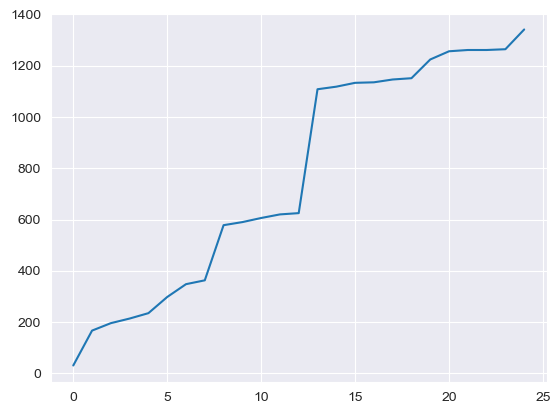

In [293]:
# Define the time period for which you want to make predictions (1 year)
years = range(0,25)
# 1 year
people_left = []
# Extract survival probabilities at 1 year for each person
for time_point in years:
    survival_at_1_year = []
    for survival_function in survival_predictions:
        # Get the survival probability at the specified time point (1 year)
        survival_at_1_year.append(survival_function(time_point))
    
    # Convert to a pandas series for easier manipulation
    survival_at_1_year = pd.Series(survival_at_1_year)
    
    # Define the threshold (e.g., 50% survival probability)
    threshold = 0.5
    
    # Count how many people are still "alive" (i.e., still working)
    still_in_company = (survival_at_1_year > threshold).sum()
    
    # Calculate the proportion of people still in the company
    proportion_still_in_company = still_in_company / len(survival_at_1_year)
    
    # Print the results
    print(f"Number of people still in the company after 1 year: {still_in_company}")
    print(f"Proportion of people still in the company after 1 year: {proportion_still_in_company:.2f}")
    # Assuming you have the total population
    total_population = len(X)
    
    # Predicted number of people still in the company
    predicted_people_left = total_population - still_in_company
    people_left.append(predicted_people_left)
    print(f"Predicted number of people who left the company after 1 year: {predicted_people_left}")
plt.figure()
plt.plot(years, people_left)
plt.show()

In [294]:
joblib.dump(rsf, "rsf_model.pkl")

['rsf_model.pkl']